# Tâche #1 : Prédiction du score NOVA d'aliments avec des modèles *Transformers*

On reprend, comme au premier travail, la tâche de prédiction du score NOVA de produits alimentaires. Cependant, des nouveaux jeux de données ont été produits. Le corpus de textes contient 3 partitions :
-	Un fichier d’entraînement -  *data/t1_nova_train.json*
-	Un fichier de validation -  *data/t1_nova_dev.json*
-	Un fichier de test - *data/t1_nova_test.json*

Utilisez la librairie *HuggingFace* pour accomplir cette tâche. On vous demande plus spécifiquement d’utiliser 2 modèles: le modèle ***bert-base-uncased*** et un **modèle encodeur multilingue** de votre choix.

Les consignes pour cette tâche sont :
- Nom du notebook : *t1_classification_nova.ipynb* (ce notebook).
- Tokenisation : Celle fournie par les tokeniseurs accompagnant les modèles transformers.
- Plongements de mots : Ceux du modèle *transformer*.
- Normalisation : Lettre en minuscule pour Bert (rien à faire, le tokenizer s’en occupe). Aucune contrainte pour le 2e modèle mais il est préférable de comparer les modèles sur une même base (lettres minuscules).
- Choix du 2e transformer: Un modèle encodeur multilingue préentraîné. Le modèle peut être une variante de Bert, mais cela n'est pas exigé. Me consulter en cas de doute pour valider votre choix.
- Entraînement : Un affinage (*fine-tuning*) des modèles encodeurs. Pas de pré-entraînement (*no further pretraining*) demandé pour cette tâche.
- Analyse : Présentez clairement vos résultats et faites-en l’analyse. Comparez les résultats obtenus avec les 2 modèles.    

Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2, etc.) si cela améliore la lisibilité.

Vous pouvez diviser cette tâche en 2 *notebooks* (un pour chaque modèle) si cela est plus simple pour vous. Dans ce cas, ajoutez le nom du modèle dans le nom du fichier (par ex. *t1_classification_nova_bert.ipynb*) et retirez les cellules prévues pour le 2e modèle.  

Notes :
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si non trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc.
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement des modèles.
- Vous pouvez ajouter des cellules au *notebook* comme bon vous semble.

Si nécessaire, installez les *packages* suivant. Si vous exécutez sur Code Colab, ces *packages* devraient déjà être installés.

In [1]:
!pip install datasets
#!pip install accelerate
!pip install "transformers[torch]"
!pip3 install torch torchvision
!pip install --upgrade transformers

In [1]:
import os

In [2]:

IN_COLAB = False

dossier_cible = '/content/drive/MyDrive/uni/nlp/nlp_tp2_models'
raccourci = '/content/nlp_tp2_models'

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

#Mount a google drive folder to save models
if IN_COLAB:
  drive.mount('/content/drive')
  os.symlink(dossier_cible, raccourci)

Mounted at /content/drive


In [3]:
repo_url = "https://github.com/XavyShmore/tp2_nlp.git"
if IN_COLAB:
  !git clone {repo_url}
  !cp -r ./tp2_nlp/data .

Cloning into 'tp2_nlp'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 5), reused 11 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 1.39 MiB | 23.76 MiB/s, done.
Resolving deltas: 100% (5/5), done.


## 1. Création du jeu de données (*les 3 partitions du dataset*)

In [4]:
train_json_fn = "./data/t1_nova_train.json"  # Jeu de données d'entraînement
dev_json_fn = "./data/t1_nova_dev.json"  # Jeu de données de validation
test_json_fn = "./data/t1_nova_test.json"  # Jeu de données de test

In [5]:
from datasets import Dataset

label2id = {"Groupe 1": 0, "Groupe 2": 1, "Groupe 3": 2, "Groupe 4": 3}
id2label = {0: "Groupe 1", 1: "Groupe 2", 2: "Groupe 3", 3: "Groupe 4"}

def load_data(json_fn):
    dataset = Dataset.from_json(json_fn)
    dataset = dataset.map(lambda nova_group: {"labels": label2id[nova_group["nova"]]})
    return dataset

In [6]:
train_dataset = load_data(train_json_fn)
dev_dataset = load_data(dev_json_fn)
test_dataset = load_data(test_json_fn)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/7651 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2126 [00:00<?, ? examples/s]

## 2. Classification des scores NOVA avec BERT

### 2.1 Modèle BERT


In [28]:
model_id = "bert-base-uncased"

In [29]:
from transformers import AutoTokenizer

def tokenize_dataset(data_set, tokenizer):
    return data_set.map(lambda examples: tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256))

def tokenize_all_dataset(train_dataset, dev_dataset, test_dataset, tokenizer = AutoTokenizer.from_pretrained(model_id)):

    train_dataset = tokenize_dataset(train_dataset, tokenizer)
    dev_dataset = tokenize_dataset(dev_dataset, tokenizer)
    test_dataset = tokenize_dataset(test_dataset, tokenizer)
    return train_dataset, dev_dataset, test_dataset

In [9]:
train_dataset, dev_dataset, test_dataset = tokenize_all_dataset(train_dataset, dev_dataset, test_dataset)

Map:   0%|          | 0/7651 [00:00<?, ? examples/s]

Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Map:   0%|          | 0/2126 [00:00<?, ? examples/s]

### 2.2 Entraînement du modèle BERT


In [31]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
model_path = "nlp_tp2_models/nova/bert"

In [32]:
def trainModel(model_id, model_path, train_dataset, eval_dataset):
  model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=4, id2label=id2label, label2id=label2id)

  args = TrainingArguments(
    output_dir=model_path + "/checkpoints",   # Dossier de sauvegarde
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    optim="adamw_torch",
    per_device_train_batch_size=128,  # Taille des lots (baisser si erreur mémoire GPU)
    per_device_eval_batch_size=256,
    num_train_epochs=6,
    weight_decay=0.01
  )
  trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
  )
  trainer.train()
  return trainer

In [33]:
trainer = trainModel(model_id, model_path, train_dataset, dev_dataset)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.379675
2,No log,0.245053
3,No log,0.208116
4,No log,0.192722
5,No log,0.197367
6,No log,0.206001


In [40]:
# Sauvegarder le modèle (le trainer contient le meilleur modèle car load_best_model_at_end=True)
trainer.save_model(model_path)

### 2.3 Évaluation du modèle BERT

In [10]:
def load_saved_model(model_path):
    """
    Charge un modèle sauvegardé à partir d'un chemin donné.
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    trainer = Trainer(model=model)
    return trainer

In [28]:
trainer = load_saved_model(model_path)
print(f"Modèle chargé avec succès depuis : {model_path}")



Modèle chargé avec succès depuis : nlp_tp2_models/nova/bert


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(trainer, dataset, id2label, title="Matrice de confusion"):
    # Faire des prédictions
    predictions_output = trainer.predict(dataset)
    preds = np.argmax(predictions_output.predictions, axis=-1)
    labels = predictions_output.label_ids

    # Calculer l'accuracy
    accuracy = accuracy_score(labels, preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Créer et afficher la matrice de confusion
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in range(len(id2label))])

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(title)
    plt.show()

    return accuracy

Accuracy: 0.9567


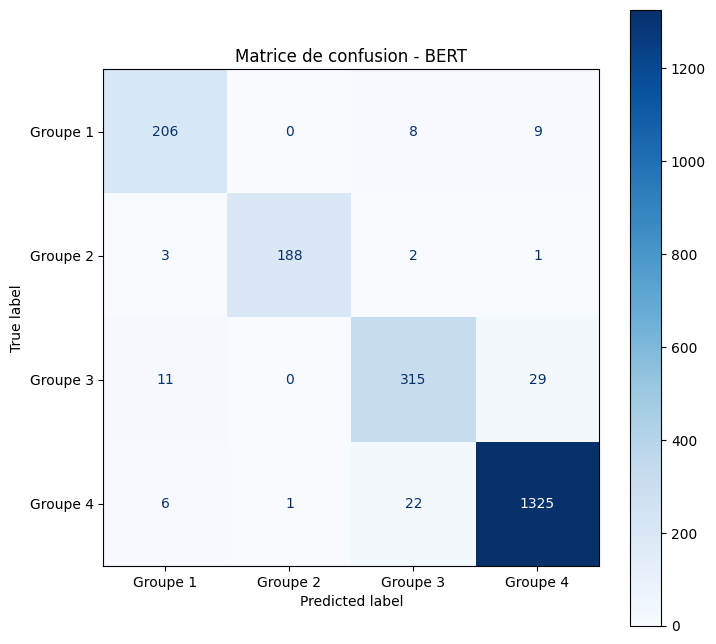

0.9567262464722484

In [34]:
evaluate_model(trainer, test_dataset, id2label, title="Matrice de confusion - BERT")

## 3. Classification des scores NOVA avec un encodeur multilingue

### 3.1  Deuxième modèle - Un encodeur multilingue

Décrivez ici le modèle que vous avez choisi. (À compléter)

### 3.2 Entraînement du deuxième modèle


In [18]:
model_path = "nlp_tp2_models/nova/other"
model_id = "microsoft/deberta-v3-small"

In [19]:
train_dataset, dev_dataset, test_dataset = tokenize_all_dataset(train_dataset, dev_dataset, test_dataset)

Map:   0%|          | 0/7651 [00:00<?, ? examples/s]

Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Map:   0%|          | 0/2126 [00:00<?, ? examples/s]

In [25]:
trainer = trainModel(model_id, model_path, train_dataset, dev_dataset)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.548614
2,No log,0.365284
3,No log,0.344821
4,No log,0.285602
5,No log,0.283972
6,No log,0.258746


In [26]:
trainer.save_model(model_path)

### 3.3 Évaluation du deuxième modèle

In [ ]:
trainer = load_saved_model(model_path)
print(f"Modèle chargé avec succès depuis : {model_path}")

Accuracy: 0.9167


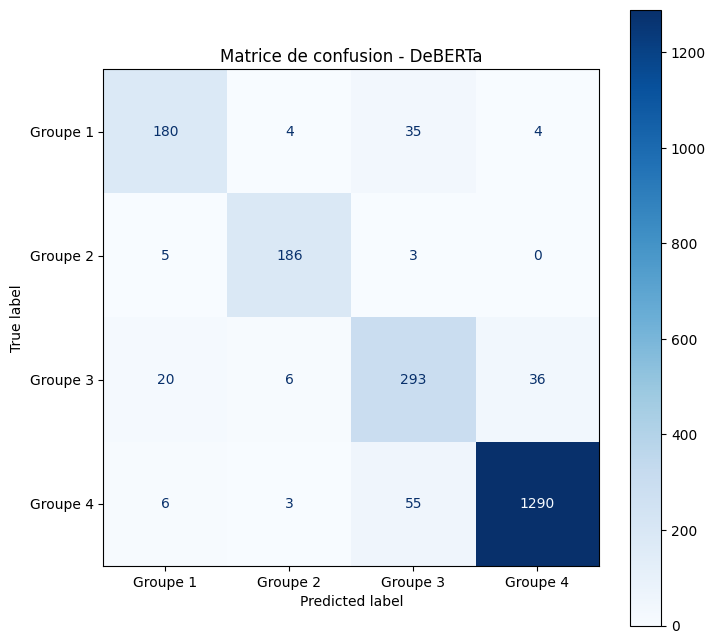

0.9167450611476952

In [27]:
evaluate_model(trainer, test_dataset, id2label, title="Matrice de confusion - DeBERTa")

## 4. Analyse des résultats et comparaison des 2 modèles